In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.stats import percentileofscore
import asyncio

#st.set_option('deprecation.showPyplotGlobalUse', False)

#st.write(datetime.now()+ timedelta(hours=2))


import requests
import telegram
import google.generativeai as genai


In [3]:

def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df


def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_arome_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run




valid_run = get_last_arome_run()

In [4]:
def get_temp_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=8&sort=0'
    url_run = f'{url}&run={valid_run}'

    temp_data = get_arome_data(url_run)

    return temp_data

def get_wind_gust_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=13&sort=0'
    url_run = f'{url}&run={valid_run}'

    wind_gust_data = get_arome_data(url_run)

    return wind_gust_data

def get_pressure_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=1&sort=0'
    url_run = f'{url}&run={valid_run}'

    pressure_data = get_arome_data(url_run)

    return pressure_data

def get_mucape_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=0&sort=0'
    url_run = f'{url}&run={valid_run}'

    mucape_data = get_arome_data(url_run)

    return mucape_data

def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data

temp_data = get_temp_data(valid_run)
wind_gust_data = get_wind_gust_data(valid_run)
pressure_data = get_pressure_data(valid_run)
mucape_data = get_mucape_data(valid_run)
prec_data = get_prec_data(valid_run)


In [9]:
datos_df_global = pd.read_csv("retiro 1950.csv",index_col="fecha",parse_dates=True)

datos_df_global = datos_df_global[~((datos_df_global.index.month == 2) & (datos_df_global.index.day == 29) & datos_df_global.index.is_leap_year)]

datos_df_global['día_del_año'] = datos_df_global.index.day_of_year

es_bisiesto = datos_df_global.index.year % 4 == 0
es_bisiesto &= (datos_df_global.index.year % 100 != 0) | (datos_df_global.index.year % 400 == 0)
marzo_en_adelante = datos_df_global.index.month >= 3
datos_df_global.loc[es_bisiesto & marzo_en_adelante, 'día_del_año'] -= 1

temp_medias = datos_df_global[["día_del_año","tmed","tmax","tmin"]]
temp_medias = temp_medias.dropna(how="any")

temp_medias_rolling = temp_medias[["tmed","tmax","tmin"]].rolling(15,center=True).mean().dropna()
temp_medias_rolling["día del año"] = temp_medias_rolling.index.day_of_year

es_bisiesto = temp_medias_rolling.index.year % 4 == 0
es_bisiesto &= (temp_medias_rolling.index.year % 100 != 0) | (temp_medias_rolling.index.year % 400 == 0)
marzo_en_adelante = temp_medias_rolling.index.month >= 3
temp_medias_rolling.loc[es_bisiesto & marzo_en_adelante, 'día del año'] -= 1

temp_medias_rolling = temp_medias_rolling.groupby("día del año").quantile([0.15, 0.85]).unstack()

In [10]:
aemet_horario = pd.read_csv("https://www.aemet.es/es/eltiempo/observacion/ultimosdatos_3195_datos-horarios.csv?k=mad&l=3195&datos=det&w=0&f=temperatura&x=h24" ,
                            encoding="latin-1",skiprows=2,parse_dates=True,index_col=0,dayfirst=True)
aemet_horario.index = aemet_horario.index.tz_localize('Europe/Madrid')



aemet_horario_acumulado = pd.read_excel("Histórico/Acumulado Madrid.xlsx",index_col=0)
aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize('Europe/Madrid')

aemet_horario_acumulado = pd.concat([aemet_horario_acumulado,aemet_horario])

aemet_horario_acumulado = aemet_horario_acumulado[~aemet_horario_acumulado.index.duplicated(keep='first')]

aemet_horario_acumulado = aemet_horario_acumulado.sort_index(ascending=False)

aemet_horario_acumulado.index = aemet_horario_acumulado.index.tz_localize(None)

In [12]:

temp_data = get_temp_data(valid_run)
temp_data["Actual data"] = aemet_horario["Temperatura (ºC)"]

In [8]:
def plot_temp_data(data):
        

        data = data
        # Set figure size and resolution
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

        # Set plot style
        plt.style.use('default')

        # Iterate over the columns and plot each one
        for column in data.columns[:-1]:
            ax.plot(data.index, data[column], alpha=0.9)

        ax.plot(data["Actual data"], alpha=1,linewidth=4,color="black")

        # Add title and labels


        plt.title('Temperature Forecast for the next 2 days', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Temperature (°C)', fontsize=12)



        # Remove top and right spines
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        # Set x-axis tick parameters
        plt.xticks(fontsize=10, rotation=0, ha='right')

        # Set y-axis tick parameters
        plt.yticks(fontsize=10)

        # Add vertical lines for each hour
        for hour in data.index:
            ax.axvline(hour, linestyle='--', color='black', alpha=0.1)

        # Remove gridlines
        plt.grid(True)

        # Compute the minimum and maximum temperature for each day and their respective indexes
        dates = list(set(data.index.date))
        min_temps = []
        max_temps = []
        min_idx = []
        max_idx = []

        for date in dates:
            df = data.loc[data.index.date == date]
            min_temp = df.min().min()
            max_temp = df.max().max()
            min_idx.append(data.loc[data.index.date == date].idxmin().min())
            max_idx.append(data.loc[data.index.date == date].idxmax().min())
            min_temps.append(min_temp)
            max_temps.append(max_temp)

        # Add the minimum temperature text to the plot
        for i, temp in enumerate(min_temps):
            min_temp = "{:.1f}".format(temp)
            ax.text(min_idx[i], temp, min_temp, ha='left', va='top', color='blue',fontweight="bold")

        # Add the maximum temperature text to the plot
        for i, temp in enumerate(max_temps):
            max_temp = "{:.1f}".format(temp)
            ax.text(max_idx[i], temp, max_temp, ha='left', va='bottom', color='red',fontweight="bold")


        max_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[0]
        max_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmax"].iloc[1]

        ax.fill_between(data.index,max_usual_temp_upper,max_usual_temp_lower, alpha=0.2, color='red')

        min_usual_temp_upper = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[0]
        min_usual_temp_lower = temp_medias_rolling.iloc[temp_data.index.day_of_year[27]]["tmin"].iloc[1]

        ax.fill_between(data.index,min_usual_temp_upper,min_usual_temp_lower, alpha=0.2, color='blue')



        # Format x-axis ticks
        # Format x-axis ticks
        ticks = []
        tick_labels = []
        for date in data.index:
                if date.hour == 0:
                    tick_labels.append(date.strftime('%A %d %B'))
                    ticks.append(date)
                    ax.axvline(date,0,1,color="black",linewidth=2)
                if date.hour % 6 == 0:
                    tick_labels.append(date.strftime('%H'))
                    ticks.append(date)
                    pass

        ax.set_xticks(ticks);
        ax.set_xticklabels(tick_labels, fontsize=10, rotation=0, ha='center');

        return 


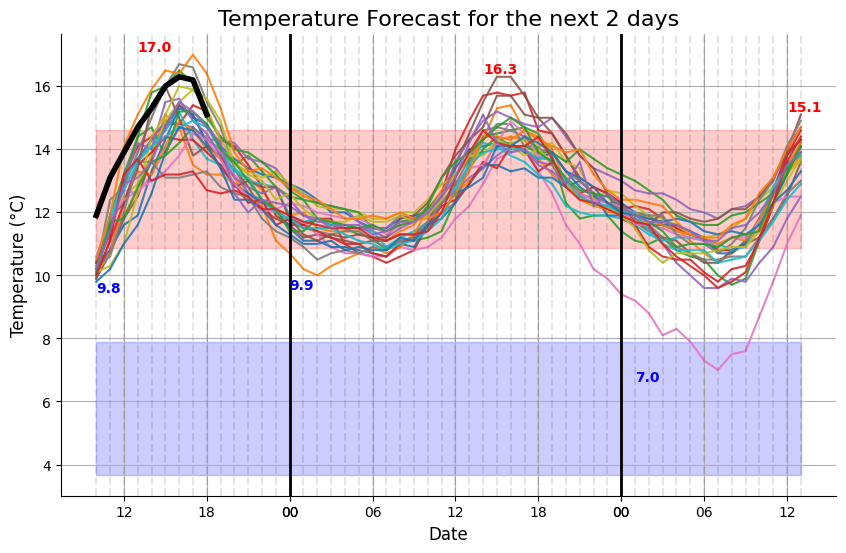

In [13]:
plot_temp_data(temp_data)

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_temp_data(data, temp_medias_rolling):
    # Set figure size, resolution, and plot style
    fig, ax = plt.subplots(figsize=(12, 7), dpi=120)
    plt.style.use('seaborn-whitegrid')

    # Define pastel color palette for forecast lines and a distinct color for actual data
    colors = plt.cm.coolwarm(np.linspace(0.2, 0.8, len(data.columns) - 1))
    for i, column in enumerate(data.columns[:-1]):
        ax.plot(data.index, data[column], color=colors[i], alpha=0.6)

    # Plot actual temperature data prominently
    ax.plot(data.index, data["Actual data"], color="black", linewidth=3)

    # Title and axis labels
    plt.title('2-Day Temperature Forecast', fontsize=18, weight='bold', color="teal")
    plt.xlabel('Date & Time', fontsize=14)
    plt.ylabel('Temperature (°C)', fontsize=14)

    # Remove top and right spines for cleaner look
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Customize x and y ticks for readability
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adding shading for usual temperature ranges (light blue for low, pink for high)
    max_temp_upper = temp_medias_rolling.loc[data.index[0].day_of_year]["tmax"].max()
    max_temp_lower = temp_medias_rolling.loc[data.index[0].day_of_year]["tmax"].min()
    ax.fill_between(data.index, max_temp_lower, max_temp_upper, alpha=0.1, color='pink')
    
    min_temp_upper = temp_medias_rolling.loc[data.index[0].day_of_year]["tmin"].max()
    min_temp_lower = temp_medias_rolling.loc[data.index[0].day_of_year]["tmin"].min()
    ax.fill_between(data.index, min_temp_lower, min_temp_upper, alpha=0.1, color='lightblue')

    # Highlight min and max temperatures for each day
    dates = list(set(data.index.date))
    for date in dates:
        day_data = data.loc[data.index.date == date]
        min_temp = day_data.min().min()
        max_temp = day_data.max().max()
        min_time = day_data.idxmin().min()
        max_time = day_data.idxmax().min()

        # Position temperature labels close to points
        ax.text(min_time, min_temp, f'{min_temp:.1f}°C', ha='right', va='top', color='blue', fontsize=10, fontweight='bold')
        ax.text(max_time, max_temp, f'{max_temp:.1f}°C', ha='right', va='bottom', color='red', fontsize=10, fontweight='bold')

    # Enhanced tick formatting without the month
    ticks = []
    tick_labels = []
    for i, date in enumerate(data.index):
        if date.hour == 0:
            ticks.append(date)
            tick_labels.append(date.strftime('%A %d'))
            ax.axvline(date, color="gray", linewidth=1, linestyle='--')
        elif date.hour % 6 == 0:
            ticks.append(date)
            tick_labels.append(date.strftime('%H'))

    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=9)

    # Display the graph
    plt.show()
    return fig



C:\Users\Iván\AppData\Local\Temp\ipykernel_20108\2925199994.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


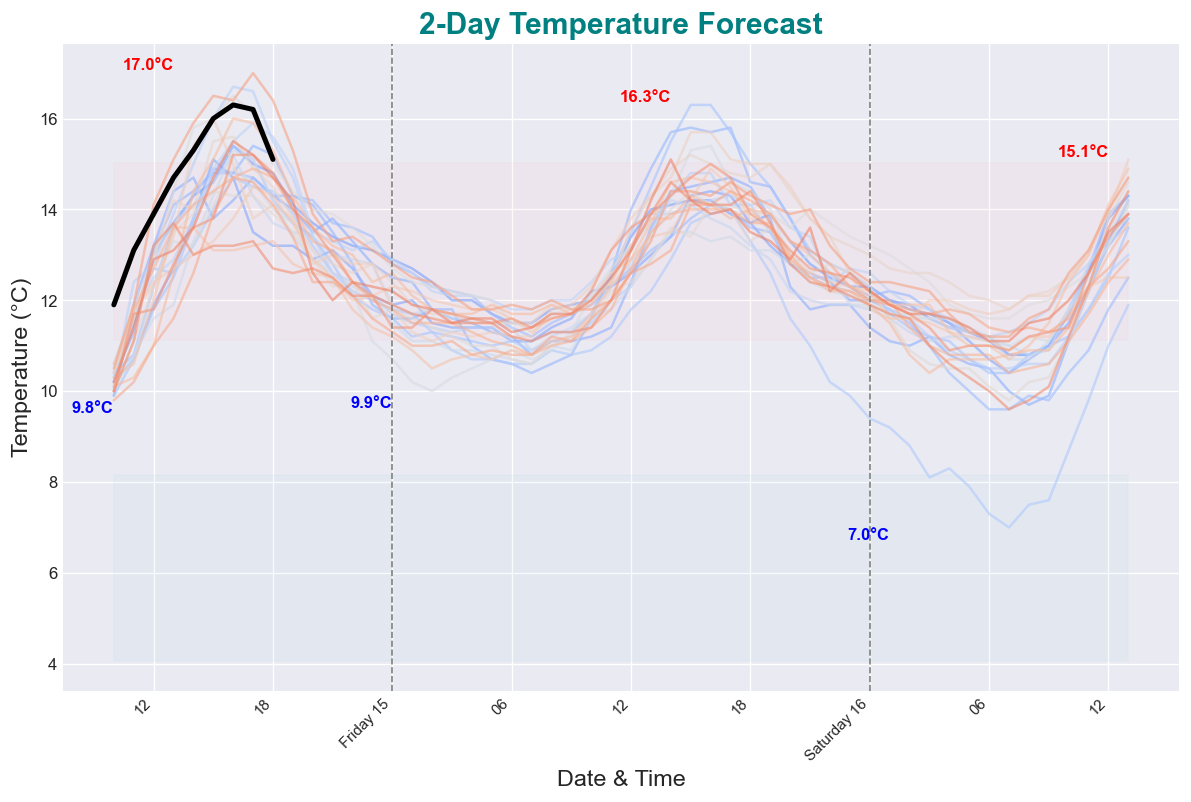

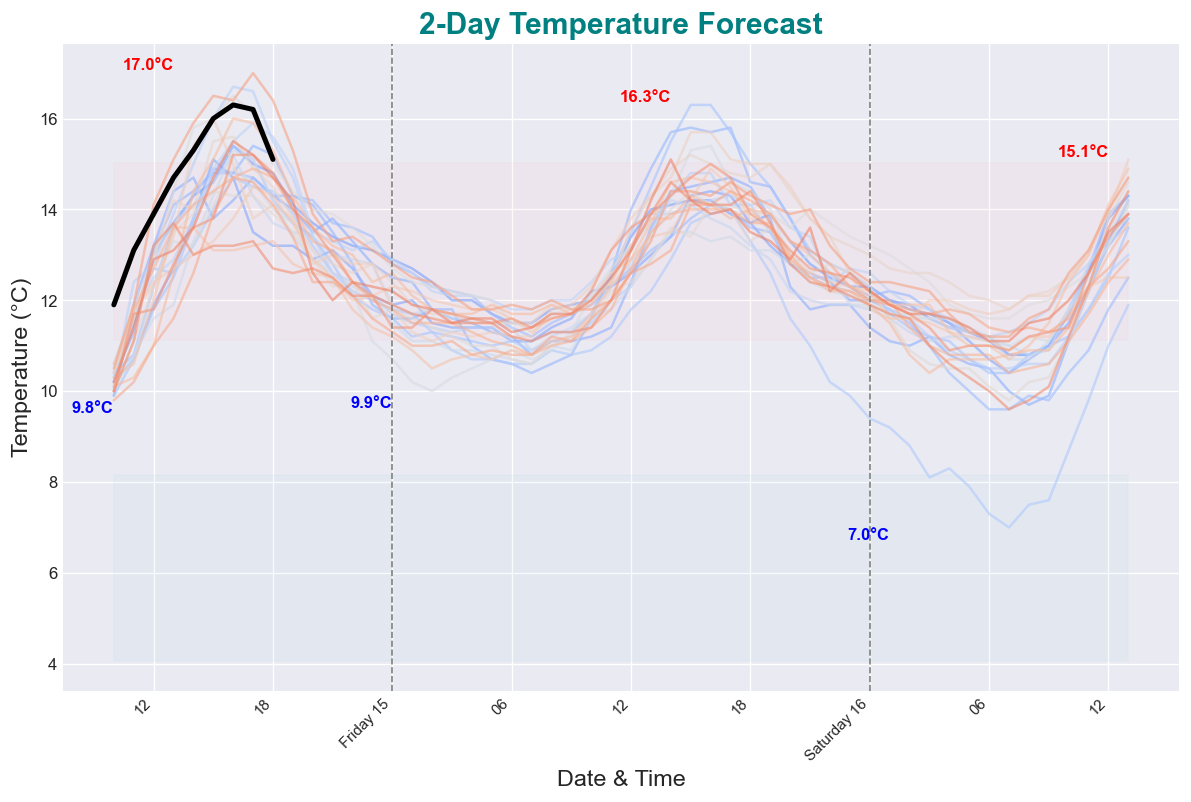

In [21]:
plot_temp_data(temp_data, temp_medias_rolling)

In [2]:
def get_arome_data(url):

#url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.658&run=9&mode=8&sort=0'  # Replace this with the URL containing the table

    url = url

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find the table element with class "gefs"
    table = soup.find('table', {'class': 'gefs'})

    # Get table rows
    rows = table.find_all('tr')

    # Extract headers from the first row
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]

    # Extract data from the remaining rows
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)

    # Create a DataFrame from the data
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])

    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop("Date",axis=1)
    df = df.drop("Ech.",axis=1)
    df = df.astype("float")

    return df



def get_last_arome_run():

    runs = [3, 9, 15, 21]
    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'

    first_index = pd.Timestamp(year=2017, month=1, day=1,tz="UTC")

    for run in runs:
        url_run = f'{url}&run={run}'
        first_index_run = get_arome_data(url_run).index[0]

        if first_index_run > first_index:
            first_index = first_index_run
            valid_run = run
        else:
            pass

    return valid_run

valid_run = get_last_arome_run()


def get_prec_data(valid_run):

    url ='https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=40.41&lon=-3.659&mode=10&sort=0'
    url_run = f'{url}&run={valid_run}'

    prec_data = get_arome_data(url_run)

    return prec_data


prec_data = get_prec_data(valid_run)
prec_data

,Ctrl,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-03 05:00:00+01:00,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-03 06:00:00+01:00,0.0,0.0,0.0,1.3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,0.0,0.5,0.0,0.0,0.0
2024-11-03 07:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-03 08:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-03 09:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-03 10:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-03 11:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-03 12:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-03 13:00:00+01:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import plotly.graph_objects as go

def get_arome_data(lat, lon, run, mode=8):
    """Descargar los datos de AROME para una latitud, longitud y run específicos."""
    url = f'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat={lat}&lon={lon}&run={run}&mode={mode}&sort=0'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Encuentra la tabla con clase 'gefs'
    table = soup.find('table', {'class': 'gefs'})
    
    # Extraer las filas de la tabla
    rows = table.find_all('tr')
    headers = [header.get_text(strip=True) for header in rows[0].find_all('td')]
    
    # Extraer los datos
    data = []
    for row in rows[1:]:
        columns = row.find_all('td')
        row_data = [column.get_text(strip=True) for column in columns]
        data.append(row_data)
    
    # Crear el DataFrame
    df = pd.DataFrame(data, columns=headers)
    df.index = pd.to_datetime(df["Date"])
    df.index = df.index.tz_convert('Europe/Madrid')
    df = df.drop(["Date", "Ech."], axis=1)
    df = df.astype("float")
    return df

def get_last_arome_run():
    """Encuentra el último 'run' válido disponible para los datos de AROME."""
    runs = [3, 9, 15, 21]
    url = 'https://www.meteociel.fr/modeles/pe-arome_table.php?x=0&y=0&lat=43.35&lon=-4.047&mode=8&sort=0'
    first_index = pd.Timestamp(year=2017, month=1, day=1, tz="UTC")
    
    for run in runs:
        try:
            first_index_run = get_arome_data(43.35, -4.047, run).index[0]
            if first_index_run > first_index:
                first_index = first_index_run
                valid_run = run
        except Exception:
            continue

    return valid_run

def get_precipitation_grid(lat_center, lon_center, valid_run, grid_size_km=3, num_points=500):
    """Obtiene una cuadrícula de datos de precipitación alrededor de un punto central."""
    # Generar la cuadrícula de puntos
    lat_range = np.linspace(lat_center - 0.135, lat_center + 0.135, num_points)  # Aproximadamente ±15 km de latitud
    lon_range = np.linspace(lon_center - 0.135, lon_center + 0.135, num_points)  # Aproximadamente ±15 km de longitud
    
    grid_data = pd.DataFrame()
    
    # Iterar sobre cada punto en la cuadrícula
    for lat in lat_range:
        for lon in lon_range:
            try:
                df_point = get_arome_data(lat, lon, valid_run, mode=8)  # Ajuste el modo según tus necesidades
                df_point['lat'] = lat
                df_point['lon'] = lon
                grid_data = pd.concat([grid_data, df_point])
            except Exception:
                print(f"Error en latitud {lat} y longitud {lon}")
                continue
    
    return grid_data


# Ejecución principal
valid_run = get_last_arome_run()
lat_center, lon_center = 40.41, -3.658
grid_data = get_precipitation_grid(lat_center, lon_center, valid_run, grid_size_km=30, num_points=10)



Error en latitud 40.455 y longitud -3.553


In [57]:
grid_size_km= 1.3*10

resolution_km = 1.3

grid_size_km % resolution_km

1.2999999999999996

In [61]:
13 / 1.3

10.0

In [62]:
1.3*10

13.0

In [68]:
import numpy as np
import pandas as pd

def get_precipitation_grid(lat_center, lon_center, valid_run, grid_size_km=1.3*40, num_points=500):
    """Obtiene una cuadrícula de datos de precipitación alrededor de un punto central."""
    
    # Asegurarse de que grid_size_km es un múltiplo de la resolución (1.3 km)
    #resolution_km = 1.3
    #if round(grid_size_km % resolution_km, 9) != 0:

    #    raise ValueError("El tamaño de la cuadrícula debe ser un múltiplo de 1.3 km.")
    
    # Calcular el número de pasos en cada dirección desde el centro
    half_extent_km = grid_size_km / 2
    num_steps = int(half_extent_km / resolution_km)  # Número de pasos en cada dirección desde el centro
    
    # Convertir la resolución en grados (aproximadamente 1.3 km por 0.012 grados)
    resolution_deg = 0.012
    
    # Generar rangos de latitud y longitud
    lat_range = np.linspace(
        lat_center - num_steps * resolution_deg,
        lat_center + num_steps * resolution_deg,
        num_points
    )
    lon_range = np.linspace(
        lon_center - num_steps * resolution_deg,
        lon_center + num_steps * resolution_deg,
        num_points
    )
    
    grid_data = pd.DataFrame()
    
    # Iterar sobre cada punto en la cuadrícula
    for lat in lat_range:
        for lon in lon_range:
            try:
                df_point = get_arome_data(lat, lon, valid_run, mode=8)  # Ajuste el modo según tus necesidades
                df_point['lat'] = lat
                df_point['lon'] = lon
                grid_data = pd.concat([grid_data, df_point])
            except Exception:
                print(f"Error en latitud {lat} y longitud {lon}")
                continue
    
    return grid_data

# Ejecución principal
valid_run = get_last_arome_run()
lat_center, lon_center = 40.41, -3.658
grid_data = get_precipitation_grid(lat_center, lon_center, valid_run, grid_size_km=30, num_points=10)

Error en latitud 40.541999999999994 y longitud -3.643333333333333


In [69]:
grid_data_ = grid_data[["Ctrl","lat","lon"]]

grid_data_ = grid_data_[grid_data.index == grid_data.index[0]]


In [70]:
grid_data_.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 99 entries, 2024-11-03 10:00:00+01:00 to 2024-11-03 10:00:00+01:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ctrl    99 non-null     float64
 1   lat     99 non-null     float64
 2   lon     99 non-null     float64
dtypes: float64(3)
memory usage: 3.1 KB


In [71]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

def create_temperature_grid_map(df):
    """
    Crea un mapa de temperaturas con cuadrículas discretas usando Plotly
    
    Parameters:
    df: DataFrame con columnas 'lat', 'lon' y 'Ctrl' (temperatura)
    
    Returns:
    figura de Plotly
    """
    # Primero, veamos los datos
    print("Rango de datos:")
    print(f"Latitudes: {df['lat'].min():.4f} a {df['lat'].max():.4f}")
    print(f"Longitudes: {df['lon'].min():.4f} a {df['lon'].max():.4f}")
    print(f"Temperaturas: {df['Ctrl'].min():.1f}°C a {df['Ctrl'].max():.1f}°C")
    
    # Crear la figura base
    fig = go.Figure()

    # Añadir las cuadrículas de temperatura
    fig.add_trace(go.Scattermapbox(
        lat=df['lat'],
        lon=df['lon'],
        mode='markers',
        marker=dict(
            size=40,  # Tamaño aumentado para mejor visibilidad
            color=df['Ctrl'],
            colorscale='RdBu_r',
            showscale=True,
            colorbar=dict(
                title='Temperatura (°C)',
                titleside='right'
            ),
            opacity=0.8,  # Añadida cierta transparencia
        ),
        text=df['Ctrl'].round(1).astype(str) + '°C',
        hovertemplate="<b>Temperatura:</b> %{text}<br>" +
                     "<b>Latitud:</b> %{lat:.4f}<br>" +
                     "<b>Longitud:</b> %{lon:.4f}<br>" +
                     "<extra></extra>"
    ))

    # Configurar el diseño del mapa
    center_lat = df['lat'].mean()
    center_lon = df['lon'].mean()
    
    # Calcular el zoom basado en el rango de los datos
    lat_range = df['lat'].max() - df['lat'].min()
    lon_range = df['lon'].max() - df['lon'].min()
    zoom = 5  # valor por defecto
    
    # Ajustar el zoom según el rango de datos
    if lat_range < 1 and lon_range < 1:
        zoom = 9
    elif lat_range < 2 and lon_range < 2:
        zoom = 8
    elif lat_range < 4 and lon_range < 4:
        zoom = 7
    
    fig.update_layout(
        mapbox=dict(
            style='carto-positron',
            center=dict(lat=center_lat, lon=center_lon),
            zoom=zoom
        ),
        margin=dict(l=0, r=0, t=30, b=0),
        title=dict(
            text='Mapa de Temperaturas por Cuadrícula',
            x=0.5,
            y=0.98
        )
    )

    return fig

# Ejemplo de uso:
fig = create_temperature_grid_map(grid_data_)
fig.show()



Rango de datos:
Latitudes: 40.2780 a 40.5420
Longitudes: -3.7900 a -3.5260
Temperaturas: 12.6°C a 14.4°C


In [19]:
#  con la información que tengo en grid_data_, plotea en un mapa tipo "carto-positron" la información para cada lat y lon distinta. haz una escala de colores e interpola entre los puntos de manera que todo el mapa se coloree. la escala debe empezar en 0

import plotly.express as px

fig = px.density_mapbox(grid_data_, lat='lat', lon='lon', z='Ctrl', radius=10,
                        center=dict(lat=lat_center, lon=lon_center), zoom=9,
                        mapbox_style="carto-positron", range_color=[0, grid_data_["Ctrl"].max()],
                        opacity=0.5, title="Precipitación acumulada en 21 horas")
fig.show()

In [11]:

import plotly.express as px

# Create the figure
fig = px.density_mapbox(grid_data_, 
                        lat='lat', 
                        lon='lon', 
                        z='21',
                        radius=20,
                        center=dict(lat=lat_center, lon=lon_center),
                        zoom=10,
                        mapbox_style="carto-positron")

# Update the colorscale to start from 0
fig.update_traces(colorscale="Viridis", zmin=0)

# Show the plot
fig.show()

